In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import emukit
import GPy
from emukit.core import ParameterSpace, ContinuousParameter, DiscreteParameter
from emukit.core.initial_designs.random_design import RandomDesign
from emukit.core.initial_designs.latin_design import LatinDesign
from GPy.models import GPRegression
from emukit.model_wrappers import GPyModelWrapper

from emukit.bayesian_optimization.loops import BayesianOptimizationLoop
from emukit.bayesian_optimization.acquisitions import ExpectedImprovement, \
                                                      NegativeLowerConfidenceBound, \
                                                      MaxValueEntropySearch, \
                                                      ProbabilityOfImprovement
from emukit.core.acquisition import IntegratedHyperParameterAcquisition



In [3]:
import pandas as pd
import os

folder_path = r'C:\Users\13282\Desktop\papercode\data\Alloy\original_processed' 
file_path = os.path.join(folder_path, 'S2_scaled.xlsx')  # y 记得加负号 ，如果需要原始值，需要反log回去

data = pd.read_excel(file_path,  header=0)  # 使用read_excel来读取Excel文件，并将header参数设置为0

# 分割数据，将第一列设为索引列，将最后一列作为y，其余列作为x
x_exp = data.iloc[:, 1:-1].values  # 假设编号列是第0列，x列从第2列到倒数第二列
y_exp = data.iloc[:, -1].values  # 最后一列作为y

# 如果需要将第一列作为索引列，可以使用以下代码
# data.set_index(data.columns[0], inplace=True)

num_rows, num_columns = data.shape


print(f"行数：{num_rows}")
print(f"列数：{num_columns}")




行数：88
列数：10


 <ipython-input-4-3e0dd6a717fd>:19: RuntimeWarning:invalid value encountered in log


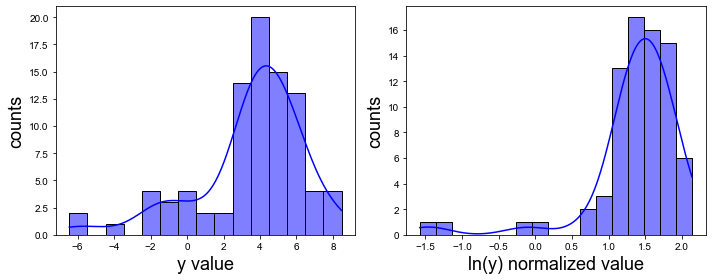

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 设置字体为Arial
plt.rcParams['font.family'] = 'Arial'

# 创建一个2x1的子图
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# 绘制原始y的分布直方图
sns.histplot(y_exp, kde=True, color='blue', ax=axes[0])
axes[0].set_xlabel('y value', fontsize=18)  # 设置x轴标签的字体大小为16
axes[0].set_ylabel('counts', fontsize=18)   # 设置y轴标签的字体大小为16
# axes[0].set_title('Distribution Histogram for Original y', fontsize=18)  # 设置标题的字体大小为18

# 对y进行对数变换
y_log = np.log(y_exp)

# 绘制对数变换后y的分布直方图
sns.histplot(y_log, kde=True, color='blue', ax=axes[1])
axes[1].set_xlabel('ln(y) normalized value', fontsize=18)  # 设置x轴标签的字体大小为16
axes[1].set_ylabel('counts', fontsize=18)  # 设置y轴标签的字体大小为16
# axes[1].set_title('Distribution Histogram for Ln-transformed y', fontsize=18)  # 设置标题的字体大小为18

# 设置坐标轴刻度字体大小
for ax in axes:
    ax.tick_params(axis='both', labelsize=10)  # 设置刻度标签的字体大小为14

plt.tight_layout()  # 调整子图布局以防止重叠
plt.show()


In [5]:
X_all, Y_all = [x_exp, -y_exp]

Y_all = Y_all.reshape(-1, 1)

print(X_all.shape)
print(Y_all.shape)

(88, 8)
(88, 1)


# 二八划分训练测试

In [8]:
from sklearn.model_selection import train_test_split

# 将X和Y按照8:2的比例划分为训练集和测试集
X_train, X_test, Y_train, Y_test = train_test_split(X_all, Y_all, test_size=0.8, random_state=42)

# gp模型

In [11]:
# 建立模型
input_dim = len(X_train[0])

ker = GPy.kern.Matern52(input_dim = input_dim, ARD = True)#

ker.lengthscale.constrain_bounded(0.01, 10) #lengthscale决定着点与点之间的相互作用程度
ker.variance.constrain_bounded(1e-2, 1e4) #方差

model_gpy = GPRegression(X_train,Y_train, ker)

model_gpy.Gaussian_noise.variance = 0.1**2
model_gpy.Gaussian_noise.variance.fix()

model_gpy.randomize()
model_gpy.optimize_restarts(num_restarts=20,verbose =False, messages=False)

base_model_1 = GPyModelWrapper(model_gpy)
# print(base_model_1.model.lengthscale)


# print(base_model_1.model.kern.lengthscale)
# print(base_model_1.model.kern.variance)



# ei_acquisition = NegativeLowerConfidenceBound(base_model_1)
# ei_plot = ei_acquisition.evaluate(X_all)
# nlcb_1 = (ei_plot - np.min(ei_plot)) / (np.max(ei_plot) - np.min(ei_plot))


reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


# nn

# 模型预测回归

Train Set Metrics:
MAE: 0.01   RMSE: 0.02   spearman: 1.0   R² score: 1.0
Test Set Metrics:
MAE: 2.63   RMSE: 3.86   spearman: 0.311   R² score: -0.789


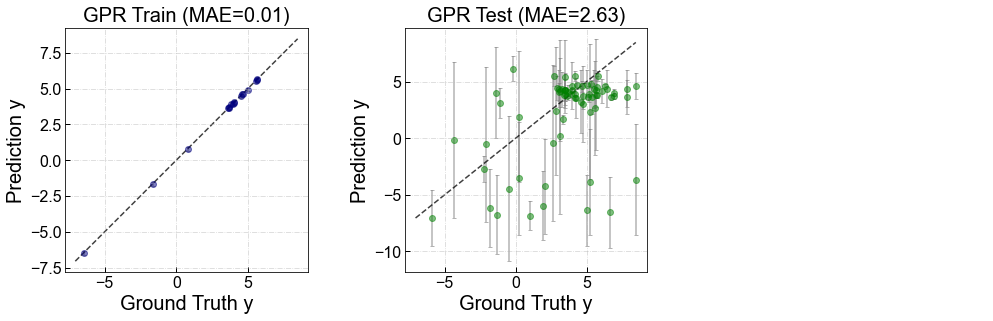

In [12]:
f_obj =  base_model_1.model.predict
y_pred, y_uncer = f_obj(X_train)
y_pred = -y_pred[:,-1]
y_uncer = np.sqrt(y_uncer[:,-1])
y_truth = -Y_train[:,-1]



# 使用测试集 X_test 进行预测
y_pred_test, y_uncer_test = f_obj(X_test)
y_pred_test = -y_pred_test[:,-1]
y_uncer_test = np.sqrt(y_uncer_test[:,-1])
y_truth_test = -Y_test[:,-1]

# 计算两个子图共享的坐标范围
min_value = min(np.min(y_truth), np.min(y_pred), np.min(y_truth_test), np.min(y_pred_test))
max_value = max(np.max(y_truth), np.max(y_pred), np.max(y_truth_test), np.max(y_pred_test))

from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
from scipy.stats import spearmanr
from matplotlib.ticker import MultipleLocator 


fig, axes = plt.subplots(1, 3, figsize=(5.5*3, 4.5))
fs = 20
# lims1 = (0, 40)
axes[0].scatter(y_truth, y_pred, alpha = 0.5, c = 'navy' , edgecolor = 'navy')
axes[0].errorbar(y_truth, y_pred, yerr = y_uncer, ms = 0, 
                 ls = '', capsize = 2, alpha = 0.6,
                 color = 'gray', zorder = 0)

axes[0].plot([min_value, max_value], [min_value, max_value], 'k--', alpha=0.75, zorder=0)

rmse_value = np.sqrt(mean_squared_error(y_truth, y_pred))
mae_value = mean_absolute_error(y_truth, y_pred)
spearman_value = spearmanr(y_truth, y_pred)[0]
rsquared_value = r2_score(y_truth, y_pred)

print('Train Set Metrics:')
print('MAE:',np.round(mae_value,2), ' ',
      'RMSE:', np.round(rmse_value,2), ' ',
      'spearman:', np.round(spearman_value,3), ' ',
      'R² score:', np.round(rsquared_value,3))

title = 'GPR Train' + " (MAE=%.2f" % mae_value+')'
axes[0].set_xlabel('Ground Truth y', fontproperties='Arial',fontsize = fs)
axes[0].set_ylabel('Prediction y',fontproperties='Arial', fontsize = fs)
axes[0].set_title(title, fontsize = fs,fontproperties='Arial')
# 设置x轴和y轴刻度一致
axes[0].axis('equal')
        
for i in range(len(axes)):
    axes[i].tick_params(direction='in', length=5, width=1, labelsize = fs*.8, grid_alpha = 0.5)
    axes[i].grid(True, linestyle='-.')
plt.subplots_adjust(wspace = 0.4)





# 计算测试集上的性能指标
rmse_value_test = np.sqrt(mean_squared_error(y_truth_test, y_pred_test))
mae_value_test = mean_absolute_error(y_truth_test, y_pred_test)
spearman_value_test = spearmanr(y_truth_test, y_pred_test)[0]
rsquared_value_test = r2_score(y_truth_test, y_pred_test)

# 创建第二个子图，绘制测试集性能
axes[1].scatter(y_truth_test, y_pred_test, alpha=0.5, c='green', edgecolor='green')
axes[1].errorbar(y_truth_test, y_pred_test, yerr=y_uncer_test, ms=0, 
                 ls='', capsize=2, alpha=0.6,
                 color='gray', zorder=0)

axes[1].plot([min_value, max_value], [min_value, max_value], 'k--', alpha=0.75, zorder=0)

title_test = 'GPR Test' + " (MAE=%.2f" % mae_value_test+')'
axes[1].set_xlabel('Ground Truth y', fontproperties='Arial', fontsize=fs)
axes[1].set_ylabel('Prediction y', fontproperties='Arial', fontsize=fs)
axes[1].set_title(title_test, fontsize=fs, fontproperties='Arial')
# 设置x轴和y轴刻度一致
# axes[1].set_xlim(-7, 10)
# axes[1].set_ylim(-7, 10)
# axes[1].axis('equal')
#  设置y轴刻度值间隔为5
y_major_locator = MultipleLocator(5)
axes[1].yaxis.set_major_locator(y_major_locator)

# 打印测试集性能指标
print('Test Set Metrics:')
print('MAE:', np.round(mae_value_test, 2), ' ',
      'RMSE:', np.round(rmse_value_test, 2), ' ',
      'spearman:', np.round(spearman_value_test, 3), ' ',
      'R² score:', np.round(rsquared_value_test, 3))




axes[2].axis("off")

plt.show()


# shap分析

In [18]:
# X_train, X_test, Y_train, Y_test = train_test_split(X_all, Y_all, test_size=0.2, random_state=42)

folder_path = r'C:\Users\13282\Desktop\papercode\data\Alloy\original_processed' 
file_path = os.path.join(folder_path, 'data.S1_scaled.xlsx')  # y 记得加负号 ，如果需要原始值，需要反log回去
data = pd.read_excel(file_path,  header=0)  # 使用read_excel来读取Excel文件，并将header参数设置为0

df_X_shap = data.iloc[:, 1:-1]

print(data.shape)

print(df_X_shap.shape)

print(X_all.shape)


(753, 36)
(753, 34)
(753, 34)


In [19]:
shap_values_list = []
for i in range(2):
    ##*******************************************##

    objective_model = base_model_1
    
    def obj_predictor_shap(X):
        X = pd.DataFrame(X)
        yc_pred, _ = objective_model.predict(np.array(X))
        y_pred_org = yc_pred.reshape(-1,1)
        return y_pred_org

    # SHAP values
    import shap    
    explainer = shap.KernelExplainer(obj_predictor_shap, shap.kmeans(df_X_shap, 10))
    shap_values = explainer.shap_values(X_all)[0]
    shap_values_list.append(shap_values)

    

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.


  0%|          | 0/753 [00:00<?, ?it/s]

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.


  0%|          | 0/753 [00:00<?, ?it/s]

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.


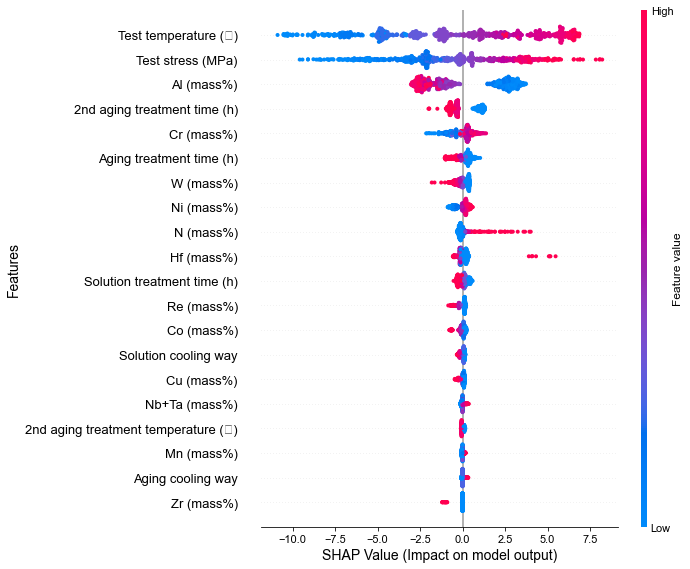

In [23]:
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "Arial"  # 替换为包含所需符号的字体
plt.rcParams['font.size'] = 1000  # 设置全局字体大小

shap_values_list_ = np.mean(shap_values_list,axis=0)

shap.summary_plot(shap_values_list_, df_X_shap,
                  plot_type = "dot", color=plt.get_cmap("plasma"), 
                  axis_color='black',
                  show = False)

# 调整 x 和 y 轴标签的字体大小
plt.xlabel('SHAP Value (Impact on model output)', fontsize=14)
plt.ylabel('Features', fontsize=14)

# # 调整图例的字体大小
# plt.legend(fontsize=12)

# # 调整刻度字体大小
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12)

# 显示图形
plt.show()

# bo迭代预测测试

In [4]:
def find_y_by_x(x_input, X_all, Y_all):  #一通过x找到对应的y的函数
    # 确保 x_input 是一个二维数组
    if len(x_input.shape) == 1:
        x_input = x_input.reshape(1, -1)

    # 初始化一个列表来存储所有结果
    all_results = []

    # 遍历 x_input 中的每个特征向量
    for x in x_input:
        # 使用 NumPy 的函数 argwhere 来查找 x 在 X 中的位置
        indices = np.argwhere(np.all(X_all == x, axis=1))

        # 初始化一个列表来存储匹配的 Y 值
        matching_y_values = []

        # 遍历匹配的位置
        for index in indices:
            match_index = index[0]
            matching_y_values.append(Y_all[match_index])

        all_results.append(matching_y_values)
    
    all_results = np.array(all_results)
    return all_results


In [6]:
# 读取CSV文件中的数据
file_path = 'data/aryl-1.csv'
data = data = pd.read_csv(file_path, encoding='utf-8', header=None)

# 删除第20列到第46列   #去除芳香卤卤化物的描述符
columns_to_drop = data.columns[19:45]  
data = data.drop(columns=columns_to_drop, axis=1)

num_rows, num_columns = data.shape

print(f"行数：{num_rows}")
print(f"列数：{num_columns}")

# 将最后一列作为y，其他列作为x
y_exp = -data.iloc[:, -1].values  # 最后一列 加 负号
x_exp = data.iloc[:, :-1].values  # 前面所有列

X_all, Y_all = [x_exp, y_exp]



行数：264
列数：95


In [25]:
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
from scipy.stats import spearmanr

df_reg= pd.DataFrame()

rmse_list = []
mae_list = []
spearman_list = []
rsquared_list = []


for _ in range(1):  # 重复求均值次数
    
    # 进行初始选点
#     np.random.seed(42)  # 设置随机种子以确保结果可重现
    num_samples_to_select = 100
    random_indices = np.random.choice(X_all.shape[0], num_samples_to_select, replace=False)

    #随机取20个点
    X = X_all[random_indices]
    Y = find_y_by_x(X, X_all, Y_all)
    
    
#     # 假设 X_all 的第47行是要添加的样本点
#     new_sample = X_all[46, :]
#     new_sample = np.array(new_sample)
#     # 在 X 中添加新样本点
#     X = np.vstack([X, new_sample])
#     Y = find_y_by_x(X, X_all, Y_all)
    
    #去除存在nan的点
    nan_indices = np.isnan(Y)
    X = X[~nan_indices.flatten()]
    Y = Y[~nan_indices.flatten()]


    # 初始化模型
    input_dim = 94

    ker = GPy.kern.Matern52(input_dim = input_dim, ARD = True)#
    
    ker.lengthscale.constrain_bounded(0.01, 5) #lengthscale决定着点与点之间的相互作用程度
    ker.variance.constrain_bounded(1e-2, 10000.0) #方差
    
    model_gpy = GPRegression(X,Y, ker)
    
    model_gpy.Gaussian_noise.variance =0.25
    model_gpy.Gaussian_noise.variance.fix()

    model_gpy.randomize()
    model_gpy.optimize_restarts(num_restarts=30,verbose =False, messages=False)

    emukit_model = GPyModelWrapper(model_gpy)
    
    
    #进行优化迭代
    maxiter = 100
    simple_regret = []
    y_min = np.nanmin(Y_all)

    for i in range(maxiter):
        emukit_model.set_data(X, Y)

        ei_acquisition = NegativeLowerConfidenceBound(emukit_model)

        ei_plot = ei_acquisition.evaluate(X_all)
        ei_acquisition_nom = (ei_plot - np.min(ei_plot)) / (np.max(ei_plot) - np.min(ei_plot))

        # values, _ = base_model.predict(X)
        # min_value = np.min(values)
        # predictions, _ = base_model.predict(x_plot)
        # improvement = np.maximum(min_value - predictions, 0)
        # improvement_nom = (improvement - np.min(improvement)) / (np.max(improvement) - np.min(improvement))
        # ei_plot = ei_acquisition_nom * w_t + improvement_nom * w_1                   #我理解的 ei+improvement

        # ei_plot = ei_acquisition_nom * w_t + ei_acquisition_1_nom * w_1                #两个ei相加

        
#将已经采样点的获取函数值设为0

        # 遍历 X 中的每一行
        for x_row in X:
            # 找到 x_row 在 X_all 中的位置索引
            indices = np.where(np.all(X_all == x_row, axis=1))[0]

            # 将对应位置上的 ei_plot 元素设置为 0
            ei_acquisition_nom[indices] = 0


        bs = 1
        sort_index = np.argsort(ei_acquisition_nom, axis =0)

        x_new = []
        top = 1 # You should set it according to your confidence in the model (balance of exploitation and exploration)
        for i in sort_index[-top:]:
                x_new.append(X_all[i][0])
                
        x_new=np.array(x_new)

        #对取样点进行检查
        found_duplicate = True
        found_nan_in_y_new = True

        while found_duplicate or found_nan_in_y_new:
            bs_index = [np.random.randint(top) for i in np.arange(bs)]
            new_x = x_new[bs_index]

            # 检查新生成的 new_x 是否在 X 中已存在
            is_duplicate = np.any(np.all(X == new_x, axis=1))

            # 更新 y_new 以匹配新的 x_new
            new_y = find_y_by_x(new_x, X_all, Y_all)

            # 检查新生成的 y_new 是否包含 NaN
            has_nan_in_y_new = np.isnan(new_y).any()

            if not is_duplicate and not has_nan_in_y_new:
                found_duplicate = False
                found_nan_in_y_new = False
                x_new = new_x
                y_new = new_y

        # 在这之后，x_new 中不含与 X 相同的元素，y_new 不含 NaN
        
#计算对于 x new 的预测情况
        
        f_obj =  emukit_model.model.predict
        y_pred, y_uncer = f_obj(x_new)
        y_pred = -y_pred[:,-1]
        y_uncer = np.sqrt(y_uncer[:,-1])
        y_truth = -y_new[:,-1]
        
        # 计算新的指标
        rmse_value_new = np.sqrt(mean_squared_error(y_truth, y_pred))
        mae_value_new = mean_absolute_error(y_truth, y_pred)
        
#         spearman_value_new = spearmanr(y_truth, y_pred)[0]
        
#         rsquared_value_new = r2_score(y_truth, y_pred)

        # 将新指标存储在列表中
        rmse_list.append(rmse_value_new)
        mae_list.append(mae_value_new)
        
#         spearman_list.append(spearman_value_new)
        
#         rsquared_list.append(rsquared_value_new)



        X = np.append(X, x_new, axis=0)
        Y = np.append(Y, y_new, axis=0)

        regret = abs(min(Y) - y_min).item()
        simple_regret.append(regret)
        
    # 将 DataFrame 追加到主 DataFrame 中
    df_reg = pd.concat([df_reg, pd.DataFrame([simple_regret])], ignore_index=True)

column_means_reg = df_reg.mean()
new_row_reg = pd.DataFrame([column_means_reg])
df_reg = pd.concat([df_reg, new_row_reg], ignore_index=True)
    
    


   

reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


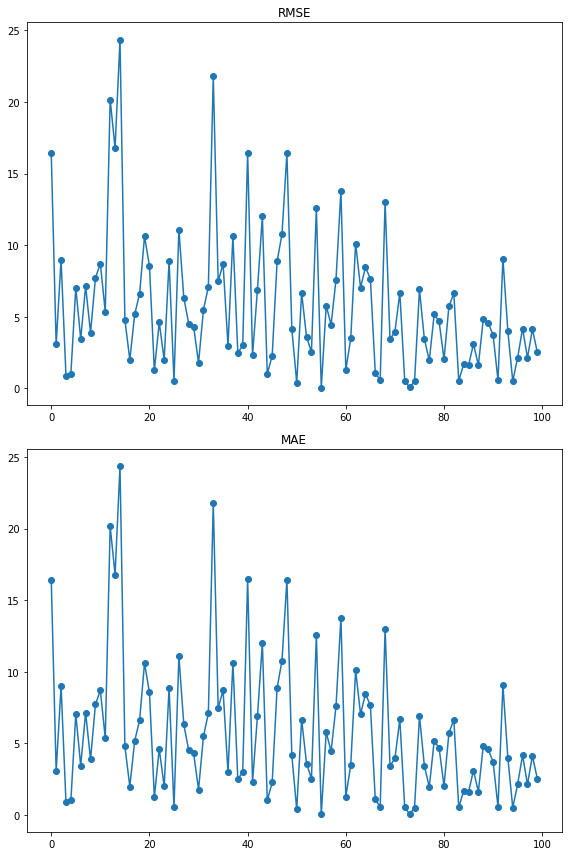

In [27]:
import matplotlib.pyplot as plt

# 创建一个4x1的子图布局
fig, axes = plt.subplots(2, 1, figsize=(8, 12))

# 创建自定义横坐标刻度
# x_values = np.arange(len(rmse_list))

# 绘制RMSE折线图
axes[0].plot(x_values, rmse_list, label='RMSE', marker='o')
axes[0].set_title('RMSE')
# axes[0].set_xticks(x_values)

# 绘制MAE折线图
axes[1].plot(x_values, mae_list, label='MAE', marker='o')
axes[1].set_title('MAE')
# axes[1].set_xticks(x_values)

# # 绘制Spearman相关系数折线图
# axes[2].plot(spearman_list, label='Spearman', marker='o')
# axes[2].set_title('Spearman Correlation')

# # 绘制R^2折线图
# axes[3].plot(rsquared_list, label='R^2', marker='o')
# axes[3].set_title('R^2')

# 设置子图之间的间距
plt.tight_layout()

# 显示图形
plt.show()


In [10]:
import numpy as np
from collections import Counter

def find_duplicate_rows(X):
    Z = X
    # 将数组中的每一行表示为元组，并将这些元组存储在列表中
    row_tuples = [tuple(row) for row in Z]

    # 使用Python的collections.Counter来计算元组的出现次数
    row_counts = Counter(row_tuples)

    # 初始化总的重复次数
    total_duplicate_count = 0

    # 创建一个集合来存储已经计数过的行
    counted_rows = set()

    # 打印重复行的行号（索引）和它们的重复次数，并计算总的重复次数
    for index, row in enumerate(Z):
        row_tuple = tuple(row)
        if row_tuple not in counted_rows:
            count = row_counts[row_tuple]
            if count > 1:
                print(f"行 {index + 1} 重复了 {count} 次")
                total_duplicate_count += count
            counted_rows.add(row_tuple)  # 将该行添加到已计数的行集合中

    # 打印总的重复次数
    print(f"总的重复次数为: {total_duplicate_count}")

    # 初始化总的不同重复行数
    total_unique_duplicate_count = 0

    # 创建一个集合来存储已经计数过的行
    counted_rows = set()

    # 计算不同的重复行数
    for row_tuple, count in row_counts.items():
        if count > 1:
            total_unique_duplicate_count += 1
            counted_rows.add(row_tuple)

    # 打印总的不同重复行数
    print(f"总的不同重复行数为: {total_unique_duplicate_count}")
    
    
find_duplicate_rows(X)




总的重复次数为: 0
总的不同重复行数为: 0


# 根据lengthscale评估参数关键度

In [10]:
print(base_model_1.model.kern.lengthscale)
print(base_model_1.model.kern.variance)

  index  |  GP_regression.Mat52.lengthscale  |  constraints  |  priors
  [0]    |                       9.99958604  |   0.01,10.0   |        
  [1]    |                       0.14060337  |   0.01,10.0   |        
  [2]    |                       9.60846765  |   0.01,10.0   |        
  [3]    |                       9.99998333  |   0.01,10.0   |        
  [4]    |                       4.37293708  |   0.01,10.0   |        
  [5]    |                       6.02037268  |   0.01,10.0   |        
  [6]    |                       9.99999984  |   0.01,10.0   |        
  [7]    |                      10.00000000  |   0.01,10.0   |        
  [8]    |                       9.99999999  |   0.01,10.0   |        
  [9]    |                       9.99923105  |   0.01,10.0   |        
  [10]   |                       9.99994268  |   0.01,10.0   |        
  [11]   |                       0.06797195  |   0.01,10.0   |        
  [12]   |                       9.83009911  |   0.01,10.0   |        
  [13]

In [11]:
print(base_model_1.model.kern.lengthscale.shape)
lengthscale = base_model_1.model.kern.lengthscale
# 找到最大的两个长度尺度的索引
top_two_indices = np.argsort(lengthscale)[-2:]

# 获取最大的两个长度尺度的值
top_two_lengthscales = lengthscale[top_two_indices]

# 打印最大的两个长度尺度的值和对应的列索引
print("最大的长度尺度值：", top_two_lengthscales)


(34,)
最大的长度尺度值：   index  |  GP_regression.Mat52.lengthscale  |  constraints  |  priors
  [8]    |                       9.99999999  |   0.01,10.0   |        
  [7]    |                      10.00000000  |   0.01,10.0   |        


In [11]:
import re

x1_index = -1
x2_index = -2

col_label_a = data.columns[x1_index-1]  
col_label_b = data.columns[x2_index-1] 

cleaned_col_label_a = re.sub(r'\([^)]*\)', '', col_label_a).strip()

cleaned_col_label_b = re.sub(r'\([^)]*\)', '', col_label_b).strip()

# 打印列标签
print("x1的列标签:", cleaned_col_label_a)

print("x2的列标签:", cleaned_col_label_b)

x1的列标签: Test stress
x2的列标签: Test temperature


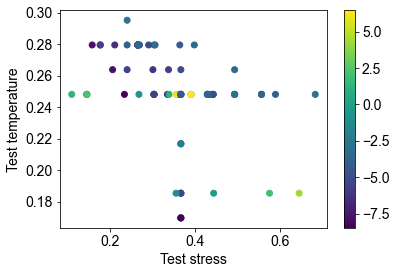

In [12]:
import matplotlib.pyplot as plt


# 设置全局字体为Arial和字号
plt.rcParams.update({'font.family': 'Arial', 'font.size': 14})

# 假设 X_all 是 (88, 34) 的二维数组，Y_all 是 (88, 1) 的数组
x = X_all[:, x1_index]  # 使用 X_all 的倒数第二列作为 x 坐标
y = X_all[:, x2_index]   # 使用 X_all 的最后一列作为 y 坐标
colors = Y_all      # 使用 Y_all 的数据作为散点的颜色

# 创建散点图
plt.scatter(x, y, c=colors, cmap='viridis', marker='o')  # 使用 'viridis' 颜色映射和圆圈标记

# 添加轴标签和标题
plt.xlabel(cleaned_col_label_a)
plt.ylabel(cleaned_col_label_b)

# 显示颜色条
cbar = plt.colorbar()

cbar.ax.yaxis.set_tick_params(labelsize=14)


# 显示图形
plt.show()
